# Experiment when multiplying two variables with common parameter


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from covariance import plot_scatter_density
import numpy as np
from numpy.random import default_rng
rng = default_rng()
N = 1000
x = rng.normal(16, 3, N)
y = rng.normal(8, 2, N)
a = rng.normal(4, 1, N)

In [3]:
import matplotlib.pyplot as plt
def compare_xy_xya(x, y, a):
    fig, axs = plt.subplots(1, 2)
    axs[0].scatter(x,y)
    axs[1].scatter(x*a, y*a)

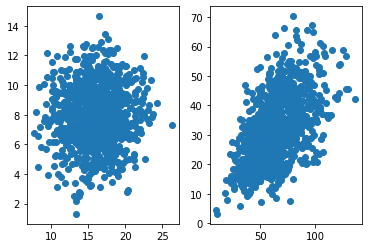

In [4]:
compare_xy_xya(x, y, a)


A correlation is clearly induced by multiplying with a common factor (even if there is no uncertainty on that factor). But it actually tells you something: x/a and y/a are correlated because of changes in a. If x/a and y/a were interesting physical quantities by themselves, then this is proof that the underlying quantities x and y are independent, but the observations are correlated due to a.

## Inherently uncorrelated: constant nh/av + noise

now let's generate some data where NH/AV is constant + noise, and try to recreate something that looks like our (av, nh, a1000) data

Here, I demonstrate what happens if a constant NH/AV and A1000/NH2 are assumed. A1000 and AV are derived from NH and NH2, with noise added. Then NH/AV and A1000/NH2 are calculated (even if assumed constant, the noise will introduce differences). The result is that the mock observations of NH/AV and A1000/NH2 are uncorrelated!

In [5]:
#assumptions

# constant gas to dust
nh_av = 2

# constant h2 to a1000
a1000_nh2 = 10


In [6]:
def mock(plot=False):
    N = 100
    a = rng.normal(4, 1, N)
    c = 2
    nh_noise = 0.5
    nh = nh_av * a + rng.normal(0, nh_noise, len(a))
    fh2 = rng.uniform(0, 1, N)
    nh2 = nh * fh2 / 2
    # let's also model a1000 with a constant a1000/NH2 ratio of ~ 11
    a1000_noise = 3
    a1000 = nh2 * a1000_nh2 + rng.normal(0, a1000_noise, len(nh2))

    if plot:
        fig, axs = plt.subplots(1, 3)
        axs[0].scatter(a, nh)
        axs[1].scatter(a1000, nh)
        axs[2].scatter(a1000, nh2)
        
        fig, axs = plt.subplots()
        axs.scatter(a1000/a, nh/a)
        
    r = np.corrcoef(a1000/a, nh/a)[0,1]
    return r 

0.09856471183362182

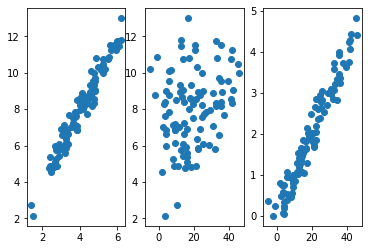

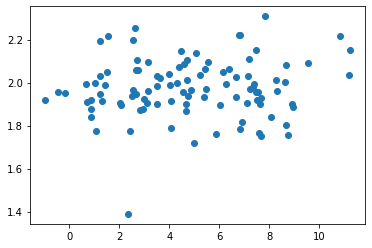

In [7]:
mock(True)

In [8]:
# N = 10000
# rhos = np.zeros(N)
# rho0s = np.zeros(N)
# xbase = a1000/a
# ybase = nh/a
# for i in range(N):
#     rhos[i] = mock()
#     xc = xbase.copy()
#     yc = ybase.copy()
#     np.random.shuffle(xc)
#     rho0s[i] = np.corrcoef(xc, yc)[0,1]


In [9]:
# plt.hist(rhos, bins=50)
# plt.hist(rho0s, bins=50)
# plt.axvline(np.median(rhos), color='k')
# print(np.median(rhos))
# print(np.std(rho0s))

# Monte Carlo Pearson test
## Model

Physical model: x and y are uncorrelated

Noise model: x' and y' strongly correlated

Question: does my Pearson coefficient method work, i.e. does it give a low correlation significance?

In [10]:
def physical_sample():
    N = 75
    mx = 0
    sx = 1
    my = 0
    sy = 1
    mr = (mx, my)
    covr = [[sx**2, 0],[0, sy**2]]
    rs = rng.multivariate_normal(mr, covr, size=N)
    return rs

def measured_sample(sigma, rho, rs = None):
    if rs is None:
        rs_real = physical_sample()
    else:
        rs_real = rs
    N = len(rs_real)
    x_unc = sigma
    y_unc = sigma
    xy_unc_cov = rho * x_unc * y_unc
    # use same covariance matrix for every point, for simplicity
    cov_unc = np.array([[x_unc**2, xy_unc_cov], [xy_unc_cov, y_unc**2]])
    unc_noise = rng.multivariate_normal((0,0), cov_unc, size=N)
    rs_measured = rs_real + unc_noise
    # create array of copies of the covariance matrix, to use in my tools
    covs = np.tile(cov_unc, (N, 1, 1))
    return rs_measured, covs

## Induced correlation: single cases

We also check what my monte carlo pearson method says, and if it results in the same conclusions we can see visually here.

In [11]:
from covariance import plot_scatter_density
from pearson import pearson_mc
from plot_fuse_results import plot_rho_box

def visual_example(sigma, rho):
    rs_p = physical_sample()
    rs, covs = measured_sample(sigma, rho, rs_p)
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    ax[0].scatter(rs_p[:,0], rs_p[:,1], marker='+', color='k')
    plot_scatter_density(ax[1], rs[:, 0], rs[:, 1], covs)
    plot_rho_box(ax[1], rs[:, 0], rs[:, 1], covs)
    ax[0].set_xlim(-5, 5)
    ax[1].set_ylim(-5, 5)
    ax[0].set_xlim(-5, 5)
    ax[1].set_ylim(-5, 5)
    fig.savefig(f"induced_correlation_example_s{sigma}_r{rho}.pdf")
    #coeff, std = pearson_mc(rs[:, 0], rs[:, 1], covs, hist_ax=ax[1])
    

### Large error + correlation = correlation induced


+++ MC pearson result +++
raw:  rho = 0.36 +- 0.06 (3.17 sigma0)
 sigmas range = 3.99 - 5.02
avg:  rho = 0.51 +- 0.06 (4.50 sigma0)
 sigmas range = 3.99 - 5.02
median:  rho = 0.51 +- 0.06 (4.52 sigma0)
 sigmas range = 3.99 - 5.02


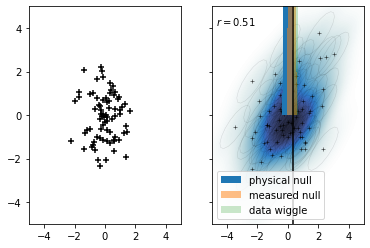

In [12]:
visual_example(1, 0.8)

### Small error + correlation = no correlation induced

+++ MC pearson result +++
raw:  rho = -0.01 +- 0.03 (-0.07 sigma0)
 sigmas range = -0.01 - 0.53
avg:  rho = 0.03 +- 0.03 (0.26 sigma0)
 sigmas range = -0.01 - 0.53
median:  rho = 0.03 +- 0.03 (0.26 sigma0)
 sigmas range = -0.01 - 0.53


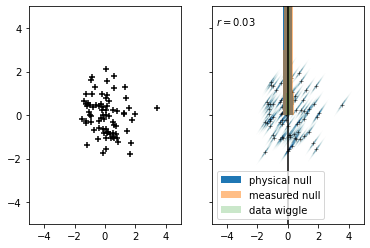

In [13]:
visual_example(.2, 0.99)

### Large error + small correlation = no induced?

With big errors, outliers might induce some correlation on rare occasions. Let's work with histograms then.

+++ MC pearson result +++
raw:  rho = 0.13 +- 0.09 (1.08 sigma0)
 sigmas range = 0.53 - 2.05
avg:  rho = 0.15 +- 0.09 (1.29 sigma0)
 sigmas range = 0.53 - 2.05
median:  rho = 0.15 +- 0.09 (1.30 sigma0)
 sigmas range = 0.53 - 2.05


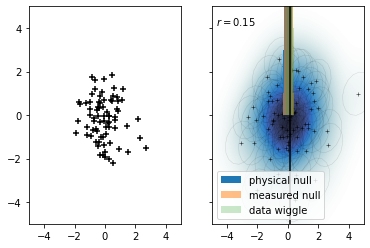

In [14]:
visual_example(1, 0.2)

## Induced correlation: ensemble -- shift of r-histogram

This first function compares the $\rho$ distributions between physical set and the set with measurement errors that might have induced correlations.

The physics and measurements are mocked many times to build histograms.

In [15]:
def compare_rhodist(sigma, rho):
    M = 1000
    rhos_physics = np.zeros(M)
    rhos_measured = np.zeros(M)
    for i in range(M):
        rs = physical_sample()
        rs_m, covs = measured_sample(sigma=sigma, rho=rho, rs=rs)
        rhos_physics[i] = np.corrcoef(rs[:, 0], rs[:, 1])[0,1]
        rhos_measured[i] = np.corrcoef(rs_m[:, 0], rs_m[:, 1])[0,1]
    plt.hist(rhos_physics,  bins=33, label='physics')
    plt.hist(rhos_measured, bins=33, label='measured')
    plt.xlabel('r')
    plt.ylabel('num')
    plt.legend()
    plt.show()
    return rhos_physics, rhos_measured

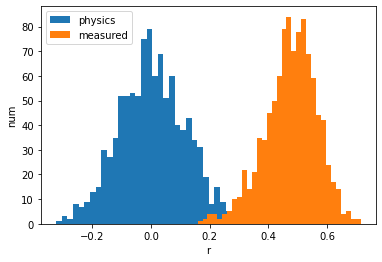

In [16]:
rhos_physics, rhos_measured = compare_rhodist(1, 0.95)

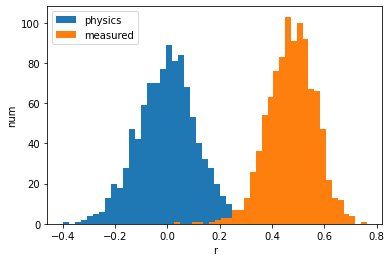

In [17]:
rhos_physics, rhos_measured = compare_rhodist(1, 0.95)

## Constructing a null hypothesis sample with induced correlation

Side note: there is such a thing as "correlation attenuation". Generally, with uncorrelated noise, the observed correlation coefficient will always be smaller than the physical correlation. This is already discussed in the original paper by Spearman (1907). Some equations for corrected correlation coefficients can be found in https://www.nature.com/articles/s41598-019-57247-4#Equ9, but those usually need the error to be the same for all data points.

Therefore, taking the median of the rho(measured) samples is not really the way to go.

Let's focus specifically on the case of A1000/AV and NH/AV. NH and A1000 are already correlated because of column density. Both also correlate with AV for the same reason. By dividing by AV, we are removing the column density factor, and looking for additional correlations. The correlation because of the uncertainty on AV makes this hard. If the uncertainty on AV is small, then there should be no problem. 

We want to create a sample of A1000/AV and NH/AV where the two are uncorrelated. This implies that both hover around some value (which could depend on AV / NH / A1000, but that effect is supressed because of the ratio). If the two ratios were uncorrelated, then we should be able to sample them independently. The only problem is knowing which shifts to use due to the measurements, and the covariance matrices to do this depend on the underlying AV/NH/A1000 values.

In my common denominator equation (see covariance.py), I need AV and sigmaAV, but not A1000 and NH! So what I could do, is sample a random underlying AV, which should be fine if AV is assumed to not correlated with A1000/AV and NH/AV. Not necessarily true, but probably good enough for this exercise, since NH vs AV looks linear.

In [18]:
# get the real data
from pearson import RandomCovMock, CommonDenominatorMock, pearson_mock_test
from rescale import RescaledData
from get_data import get_merged_table, get_xs_ys_covs, get_param_and_unc
data = get_merged_table()
xs, ys, covs = get_xs_ys_covs(data, "A1000_AV", "NH_AV")
ignore_high = ys < 4e21
xs = xs[ignore_high]
ys = ys[ignore_high]
covs = covs[ignore_high]
rd = RescaledData(xs, ys, covs, xfactor_yfactor=(1, 1e-21))
xs1, ys1, covs1 = rd.xs, rd.ys, rd.covs
# make the covs bigger to see if the method is working properly
#covs1[:, 0, 1] = 0.95 * np.sqrt(covs1[:,0,0] * covs1[:,1,1])
#covs1[:, 1, 0] = covs1[:, 0, 1]

avs, avs_unc = get_param_and_unc('AV', data)
avs = avs[ignore_high]
avs_unc = avs_unc[ignore_high]

denom_mock = CommonDenominatorMock(xs1, ys1, covs1, avs, avs_unc)
random_mock = RandomCovMock(xs1, ys1, covs1)

Did not find absolute magnitude for B2Ve
Took 39 distances from Shull+21


/Users/dvandeputte/Projects/FUSE H2/data_analysis/get_data.py:14: RuntimeWarning: overflow encountered in power
  lin = np.power(10.0, log)
/Users/dvandeputte/Projects/FUSE H2/data_analysis/get_data.py:15: RuntimeWarning: overflow encountered in power
  lin_unc = 0.5 * (np.power(10.0, log + log_unc) - np.power(10.0, log - log_unc))
/Users/dvandeputte/Projects/FUSE H2/data_analysis/get_data.py:15: RuntimeWarning: invalid value encountered in subtract
  lin_unc = 0.5 * (np.power(10.0, log + log_unc) - np.power(10.0, log - log_unc))


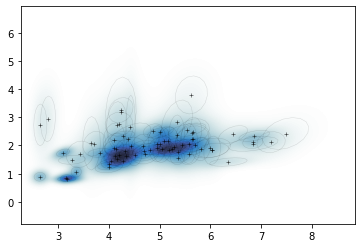

In [19]:
plot_scatter_density(plt.gca(), xs1, ys1, covs1)

/Users/dvandeputte/Projects/FUSE H2/data_analysis/pearson.py:342: RuntimeWarning: covariance is not positive-semidefinite.
  [np.random.multivariate_normal((xs[i], ys[i]), covs[i]) for i in range(len(xs))]


{'real_rho': 0.2598693630237792,
 'null_rho': 0.023734270219964493,
 'as measured': 1.9982752831821755,
 'median of wiggle': 1.6736087072985448}

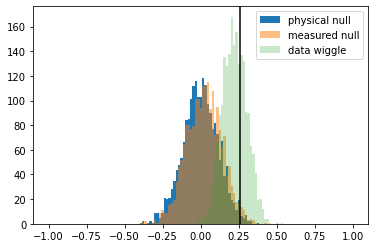

In [20]:
# try the common denom method
pearson_mock_test(denom_mock)

{'real_rho': 0.2598693630237792,
 'null_rho': 0.026663640892035212,
 'as measured': 1.925621010686653,
 'median of wiggle': 1.5984944247561037}

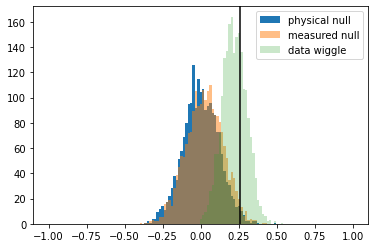

In [21]:
# try the common denom method
pearson_mock_test(random_mock)

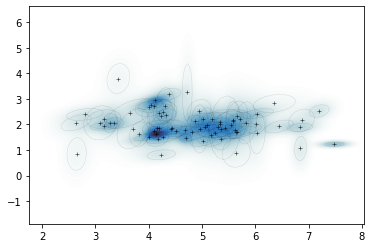

In [22]:
plot_scatter_density(plt.gca(), *random_mock.mock())

### Same with A2175

In [27]:
xs, ys, covs = get_xs_ys_covs(data, "A2175_AV", "NH_AV")
ignore_high = ys < 4e21
xs = xs[ignore_high]
ys = ys[ignore_high]
covs = covs[ignore_high]
rd = RescaledData(xs, ys, covs, xfactor_yfactor=(1, 1e-21))
xs2, ys2, covs2 = rd.xs, rd.ys, rd.covs

# make the covs bigger to see if the method is working properly
# covs2[:, 0, 1] = 0.95 * np.sqrt(covs2[:,0,0] * covs2[:,1,1])
# covs2[:, 1, 0] = covs2[:, 0, 1]
# covs2 *= 4
# cov matrix needs to be adjust correctly along with avs_unc. 
# Only straightforward if the original data are used.
# just scaling the cov matrix should work better

# if I don't adjust avs_unc here, then the common demoninator 
# method will not work correctly for this made up scenario with inflated covs.
factor = 4
avs_unc_boost = factor * avs_unc
covs2 *= factor * factor

denom_mock2 = CommonDenominatorMock(xs2, ys2, covs2, avs, avs_unc_boost)
random_mock2 = RandomCovMock(xs2, ys2, covs2)

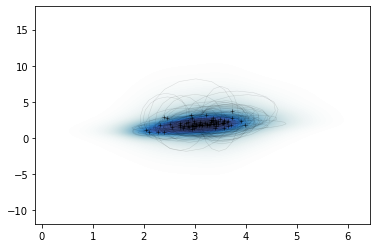

In [28]:
plot_scatter_density(plt.gca(), xs2, ys2, covs2)

{'real_rho': 0.42504291680757794,
 'null_rho': 0.1323190641589465,
 'as measured': 2.432623886277024,
 'median of wiggle': 0.5958652370682589}

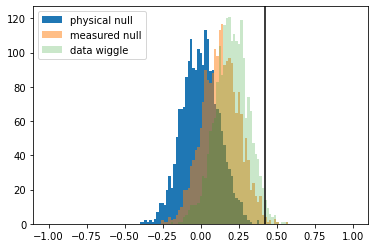

In [29]:
# try the common denom method
pearson_mock_test(denom_mock2)

{'real_rho': 0.42504291680757794,
 'null_rho': 0.1391322546696465,
 'as measured': 2.4544405609815723,
 'median of wiggle': 0.5694840811976052}

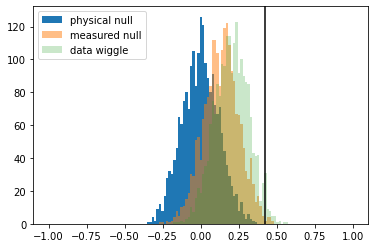

In [30]:
# try the common denom method
pearson_mock_test(random_mock2)